Extract HuBERT codes over TIMIT words/syllables

In [184]:
from pathlib import Path
import re

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile
import torch
import transformers
from tqdm.auto import tqdm

In [243]:
model_ref = "facebook/hubert-large-ls960-ft" # "facebook/hubert-base-ls960"
layers = np.floor(np.linspace(0, 24, num=10)).astype(int)
levels = ["word", "phoneme"]
pooling_method = "mean"

sample_rate = 16000

out_file = "timit_hubert_encodings.h5"

## Load sound data

In [3]:
files = list(Path("data/TRAIN").glob("*/*/*.WAV"))

# tuples (dialect, speaker, sentence_idx)
labels = [re.findall(r"([^/]+)/([^/]+)/([^/]+)\.WAV", str(file))[0] for file in files]

In [14]:
if sample_rate != 16000:
    raise NotImplementedError("only support 16 kHz sample rate")

sounds = []
for file in tqdm(files):
    sound_i, sfreq_i = soundfile.read(file, dtype="float32")
    assert sfreq_i == sample_rate, "Mismatched sample rate"
    sounds.append(sound_i)

  0%|          | 0/4620 [00:00<?, ?it/s]

In [15]:
sounds = [torch.from_numpy(sound) for sound in sounds]

### Load aligned data

In [52]:
aligned_df = pd.read_csv("timit_merged.csv").set_index(["dialect", "speaker", "sentence_idx"])
for col in ["onset", "offset", "offset_word"]:
    aligned_df[f"{col}_time"] = aligned_df[col] / sample_rate
aligned_df

phone_idx  onset  offset phone  word_idx  \
dialect speaker sentence_idx                                             
DR1     FCJF0   SA1                   0      0    3050    h#       NaN   
                SA1                   1   3050    4559    sh       0.0   
                SA1                   2   4559    5723    ix       0.0   
                SA1                   3   5723    6642    hv       1.0   
                SA1                   4   6642    8772    eh       1.0   
...                                 ...    ...     ...   ...       ...   
DR8     MTCS0   SX82                 29  34460   36386    ih       7.0   
                SX82                 30  36386   38150   pcl       7.0   
                SX82                 31  38150   38575     p       7.0   
                SX82                 32  38575   40870     s       7.0   
                SX82                 33  40870   43360    h#       7.0   

                              offset_word  word  onset_time  offset_time  \
dialect speaker sentence_idx                                               
DR1     FCJF0   SA1                   NaN   NaN    0.000000     0.190625   
                SA1                5723.0   she    0.190625     0.284938   
                SA1                5723.0   she    0.284938     0.357687   
                SA1               10337.0   had    0.357687     0.415125   
                SA1               10337.0   had    0.415125     0.548250   
...                                   ...   ...         ...          ...   
DR8     MTCS0   SX82              40870.0  tips    2.153750     2.274125   
                SX82              40870.0  tips    2.274125     2.384375   
                SX82              40870.0  tips    2.384375     2.410938   
                SX82              40870.0  tips    2.410938     2.554375   
                SX82              40870.0  tips    2.554375     2.710000   

                              offset_word_time  
dialect speaker sentence_idx                    
DR1     FCJF0   SA1                        NaN  
                SA1                   0.357687  
                SA1                   0.357687  
                SA1                   0.646062  
                SA1                   0.646062  
...                                        ...  
DR8     MTCS0   SX82                  2.554375  
                SX82                  2.554375  
                SX82                  2.554375  
                SX82                  2.554375  
                SX82                  2.554375  

[177080 rows x 10 columns]

In [128]:
aligned_word_df = aligned_df[~aligned_df.word_idx.isna()].set_index("word_idx", append=True)
aligned_word_df = aligned_word_df.loc[~aligned_word_df.index.duplicated()] \
    .drop(columns=["phone_idx", "offset", "offset_time", "phone"]).rename(columns={"offset_word": "offset", "offset_word_time": "offset_time"}) \
    .astype(dict(onset=int, offset=int))
aligned_word_df

onset  offset      word  onset_time  \
dialect speaker sentence_idx word_idx                                        
DR1     FCJF0   SA1          0.0        3050    5723       she    0.190625   
                             1.0        5723   10337       had    0.357687   
                             2.0        9190   11517      your    0.574375   
                             3.0       11517   16334      dark    0.719812   
                             4.0       16334   21199      suit    1.020875   
...                                      ...     ...       ...         ...   
DR8     MTCS0   SX82         3.0       17110   18920        be    1.069375   
                             4.0       18920   26520  rewarded    1.182500   
                             5.0       26520   28490        by    1.657500   
                             6.0       28490   33770       big    1.780625   
                             7.0       33770   40870      tips    2.110625   

                                       offset_time  
dialect speaker sentence_idx word_idx               
DR1     FCJF0   SA1          0.0          0.357687  
                             1.0          0.646062  
                             2.0          0.719812  
                             3.0          1.020875  
                             4.0          1.324938  
...                                            ...  
DR8     MTCS0   SX82         3.0          1.182500  
                             4.0          1.657500  
                             5.0          1.780625  
                             6.0          2.110625  
                             7.0          2.554375  

[39825 rows x 5 columns]

### Validate aligned data

In [102]:
from IPython.display import HTML, Audio

In [97]:
random_words = aligned_word_df.sample(n=5)
random_words

,,,,onset,offset,word,onset_time,offset_time
dialect,speaker,sentence_idx,word_idx,,,,,
DR4,MJJJ0,SX443,8.0,35960,41650.0,sky,2.247500,2.603125
DR2,FMMH0,SA1,10.0,43755,47724.0,year,2.734688,2.982750
DR7,MRMH0,SI2281,5.0,31803,35210.0,her,1.987688,2.200625
DR3,MRWA0,SX343,9.0,42780,48520.0,brother,2.673750,3.032500
DR2,MJHI0,SA2,9.0,31320,35676.0,that,1.957500,2.229750


In [108]:
sound_dict = dict(zip(labels, sounds))
for label, word_row in random_words.iterrows():
    sound = sound_dict[label[:3]]
    # Slice out word
    sound = sound[word_row.onset:int(word_row.offset)]
    display(word_row.word, Audio(sound, rate=sample_rate))

'sky'

'year'

'her'

'brother'

'that'

---

In [196]:
model = transformers.AutoModel.from_pretrained(model_ref)
processor = transformers.AutoProcessor.from_pretrained(model_ref)

In [197]:
# Width of a single frame in HuBERT sequence representation, in ms
frame_width = 20

In [198]:
# Store HuBERT frame corresponding to onset/offset
time_to_frame = lambda x: np.floor(x * 1000 / frame_width).astype(int)
aligned_df["onset_frame"] = aligned_df["onset_time"].transform(time_to_frame)
aligned_df["offset_frame"] = aligned_df["offset_time"].transform(time_to_frame)
aligned_word_df["onset_frame"] = aligned_word_df["onset_time"].transform(time_to_frame)
aligned_word_df["offset_frame"] = aligned_word_df["offset_time"].transform(time_to_frame)
aligned_word_df

onset  offset      word  onset_time  \
dialect speaker sentence_idx word_idx                                        
DR1     FCJF0   SA1          0.0        3050    5723       she    0.190625   
                             1.0        5723   10337       had    0.357687   
                             2.0        9190   11517      your    0.574375   
                             3.0       11517   16334      dark    0.719812   
                             4.0       16334   21199      suit    1.020875   
...                                      ...     ...       ...         ...   
DR8     MTCS0   SX82         3.0       17110   18920        be    1.069375   
                             4.0       18920   26520  rewarded    1.182500   
                             5.0       26520   28490        by    1.657500   
                             6.0       28490   33770       big    1.780625   
                             7.0       33770   40870      tips    2.110625   

                                       offset_time  onset_frame  offset_frame  
dialect speaker sentence_idx word_idx                                          
DR1     FCJF0   SA1          0.0          0.357687            9            17  
                             1.0          0.646062           17            32  
                             2.0          0.719812           28            35  
                             3.0          1.020875           35            51  
                             4.0          1.324938           51            66  
...                                            ...          ...           ...  
DR8     MTCS0   SX82         3.0          1.182500           53            59  
                             4.0          1.657500           59            82  
                             5.0          1.780625           82            89  
                             6.0          2.110625           89           105  
                             7.0          2.554375          105           127  

[39825 rows x 7 columns]

In [223]:
def model_forward(sound_data: np.ndarray, **kwargs):
    with torch.no_grad():
        ret = model.forward(**processor(sound_data, sampling_rate=sample_rate, return_tensors="pt"), **kwargs)
    return ret

## Visualize

In [224]:
visualize_idx = 0
visualize_labels = labels[visualize_idx]

In [229]:
out = model_forward(sounds[visualize_idx], output_attentions=True)

In [230]:
def show_attentions(head_idxs, figsize=(10, 10), label_words=True):
    f, axs = plt.subplots(len(head_idxs), figsize=figsize)
    aligned_words = aligned_word_df.loc[visualize_labels]
    
    for head_idx, ax in zip(head_idxs, axs.ravel()):
        sns.heatmap(out.attentions[5][0, head_idx], ax=ax)
        
        if label_words:
            word_frames = np.floor(aligned_words.onset_time * 1000 / frame_width)
            ax.set_xticks(aligned_words.onset_frame)
            ax.set_xticklabels(aligned_words.word)
            ax.set_yticks(aligned_words.onset_frame)
            ax.set_yticklabels(aligned_words.word)

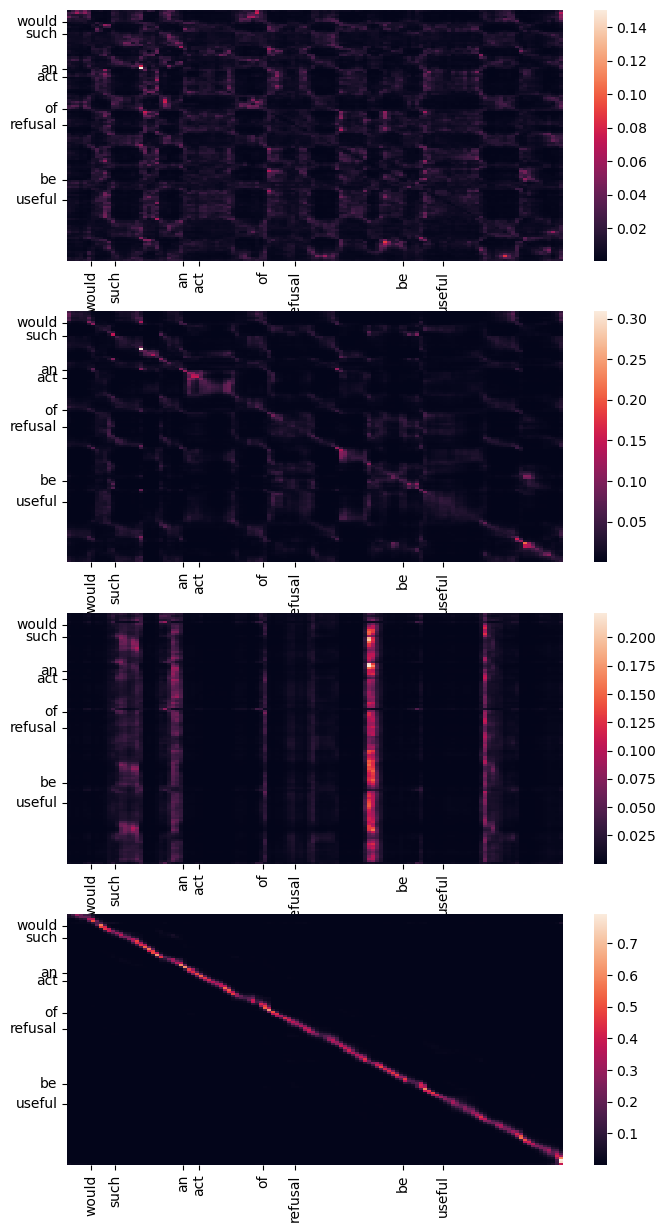

In [231]:
show_attentions([0, 1, 2, 3], figsize=(8, 15))

## Prepare for extraction

In [170]:
aligned_word_df

onset  offset      word  onset_time  \
dialect speaker sentence_idx word_idx                                        
DR1     FCJF0   SA1          0.0        3050    5723       she    0.190625   
                             1.0        5723   10337       had    0.357687   
                             2.0        9190   11517      your    0.574375   
                             3.0       11517   16334      dark    0.719812   
                             4.0       16334   21199      suit    1.020875   
...                                      ...     ...       ...         ...   
DR8     MTCS0   SX82         3.0       17110   18920        be    1.069375   
                             4.0       18920   26520  rewarded    1.182500   
                             5.0       26520   28490        by    1.657500   
                             6.0       28490   33770       big    1.780625   
                             7.0       33770   40870      tips    2.110625   

                                       offset_time  onset_frame  offset_frame  
dialect speaker sentence_idx word_idx                                          
DR1     FCJF0   SA1          0.0          0.357687            9            17  
                             1.0          0.646062           17            32  
                             2.0          0.719812           28            35  
                             3.0          1.020875           35            51  
                             4.0          1.324938           51            66  
...                                            ...          ...           ...  
DR8     MTCS0   SX82         3.0          1.182500           53            59  
                             4.0          1.657500           59            82  
                             5.0          1.780625           82            89  
                             6.0          2.110625           89           105  
                             7.0          2.554375          105           127  

[39825 rows x 7 columns]

In [232]:
def pool_frames(hidden_states: torch.Tensor, start_frame, end_frame, layers: list[int], pooling_method="mean"):
    """
    Extract representations pooled over the given layer range.
    
    Returns a tensor num_layers * hidden_dim
    """
    pool = getattr(torch, pooling_method)
    return torch.stack([
        pool(hidden_states[layer].squeeze(0)[start_frame:end_frame], dim=-2)
        for layer in layers
    ])

def extract_word_representations(sound_ref: tuple, layers: list[int], pooling_method="mean"):
    """
    Extract representations for a series of words.
    """
    
    sound = sound_dict[sound_ref]
    with torch.no_grad():
        out = model_forward(sound, output_hidden_states=True)
        
    return torch.stack([
        pool_frames(out.hidden_states, word.onset_frame, word.offset_frame,
                    layers, pooling_method=pooling_method)
        for _, word in aligned_word_df.loc[sound_ref].iterrows()
    ])

In [244]:
with h5py.File(out_file, "w") as f:
    for label, sound in tqdm(sound_dict.items()):
        h5_key = "/".join(label)
        f[f"{h5_key}/representations/word/{pooling_method}"] = extract_word_representations(label, layers=layers, pooling_method=pooling_method)

  0%|          | 0/4620 [00:00<?, ?it/s]